In [153]:
%matplotlib widget
from gekko import GEKKO
import numpy as np
import pandas as pd
from random import random
import matplotlib.pyplot as plt
import requests
plt.ion()


# Get CO2 Data

request url: https://api.energidataservice.dk/dataset/CO2EmisProg?start=2024-01-01T00%3A00&end=2024-01-17T00%3A00&filter=%7B%22PriceArea%22%3A%5B%22DK2%22%5D%7D&sort=Minutes5UTC+ASC
status code: 200



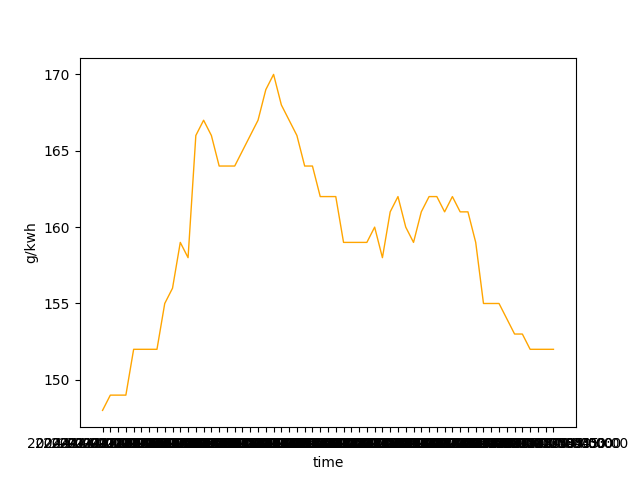

In [154]:
# Get CO2 Data
response = requests.get(url='https://api.energidataservice.dk/dataset/CO2EmisProg', params={"start": "2024-01-01T00:00","end":"2024-01-17T00:00","filter":"{\"PriceArea\":[\"DK2\"]}","sort":"Minutes5UTC ASC"})
print(f"request url: {response.request.url}")
print(f"status code: {response.status_code}", end="\n\n")

if response.ok:
	result = response.json()
	df_co2 = pd.DataFrame(result["records"])	
else:
	df_co2 = pd.DataFrame()
	raise f"Returned status {response.status_code}: {response.text}"

plt.figure()
plt.plot(df_co2["Minutes5DK"][0:59].values,df_co2["CO2Emission"][0:59].values,color='orange',linewidth=1)

plt.xlabel('time')
plt.ylabel('g/kwh')
#plt.legend()
plt.show()  


# Setup the MPC

In [155]:
h_hist = [200]    # Inital height
w_hist = [0]

m = GEKKO()
m.options.SOLVER = 1 # APOPT solver


#time horizon: 6h
Thor = int(1*60) #sec
Ts = 1 #sec
n = Ts*Thor
m.time = np.linspace(0,int(Thor-1),n)

# Manipulated variable
w = m.MV(value=w_hist[0], lb = 0, ub = 1500,integer=True)
w.STATUS = 1  # allow optimizer to change
w.DCOST = 0.05 # smooth out gas pedal movement
#w.DMAX = 20   # slow down change of gas pedal

# Controlled Variable
Qout = m.CV(value=0)
P = m.CV(value=0)
h = m.CV(value=h_hist[0])
#m.options.CV_TYPE = 2 # squared error



m.options.CV_TYPE = 1 # Linear error with deadband
eH = m.CV(value=0)
eH.SPHI=0         #Set point high for linear error model.
eH.WSPHI=10000    #Objective function weight on upper set point for linear error model.
eH.WSPLO=0        # Objective function weight on lower set point for linear error model
eH.STATUS =1      # eH : Error is considered in the objective function.

eL = m.CV(value=0)
eL.SPLO=0
eL.WSPHI=10     # key weight influencing attraction to lower levels
eL.WSPLO=0
eL.STATUS = 1    

# CO2 Values
#co2 = np.random.randint(70,100,size=n)
#x_values = np.linspace(0, 2 * np.pi, n)
x_values = np.linspace(0, 3 * np.pi, n)
y_values = np.sin(x_values)*30
noise_factor = 1
co2 = y_values + noise_factor * np.random.normal(size=len(y_values))+60

#co2 = 100*np.ones(n)


c = m.Param(value=co2)
m.Minimize(c*P)

# Process model
A_power = np.array([[3.7971E-01],\
                    [5.1151E-02],\
                    [3.1656E-01]])
A_outflow = np.array([[1.2995],\
                    [-4.3918E-01],\
                    [4.5231E-02],\
                    [0],\
                    [1.0387E-02]])

# B (ny x (nb x nu))
B_power = np.array([[[5.5404E-02],[-1.4118E-02],[-2.3452E-02]]]).T
B_outflow = np.array([[[7.1049E-02],[4.1327E-02],[6.4801E-02],[0],[-6.6199E-02]]]).T

C_power = np.array([-6.6831])
C_outflow = np.array([-7.3292E+01])

# C_power = np.array([0])
# C_outflow = np.array([0])

p_power = {'a':A_power,'b':B_power,'c':C_power}
p_outflow = {'a':A_outflow,'b':B_outflow,'c':C_outflow}

# Qout = m.if3(w-750,0,Qout)


m.arx(p_power,P,w)
m.arx(p_outflow,Qout,w)

#P = m.if3(w-750,0,P_c)
#Qout = m.if3(w-750,0,Qout_c)


m.Equation(h.dt() == 1/18 *(75 - Qout)/3600*100)
#m.Equation(h.dt() == 1/18 *(75 - m.if3(w-750,0,Qout))/3600*100)
dh = m.Var()
m.Equation(h.dt() == dh*100)
m.Equations([eH==h-200,eL==h-120]) # Errors

m.options.IMODE = 6 # control

#m.solve(disp=False)

# for i in range(1,2):
#     # Read "Measurement" of: Height, Qin, and Qout
#     #h.MEAS = h_hist[i-1]
    
    
#     m.solve(disp=False)

#     # Save new Pumpspeed
#     w_hist.append(w.NEWVAL)


#     #print(w.LSTVAL)
#     #print(w.NEWVAL)
#     #h_hist.append(h.Value[0])


apm 192.38.81.6_gk_model48 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :            8
   Intermediates:            0
   Connections  :            4
   Equations    :            5
   Residuals    :            5
 
 Number of state variables:           4661
 Number of total equations: -         4602
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             59
 
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      8.48 NLPi:    7 Dpth:    0 Lvs:    3 Obj:  1.07E+05 Gap:       NaN
Iter:     2 I:  0 Tm:      1.68 NLPi:    3 Dpth: 

The emitted CO2 is 13.877148320493111 g


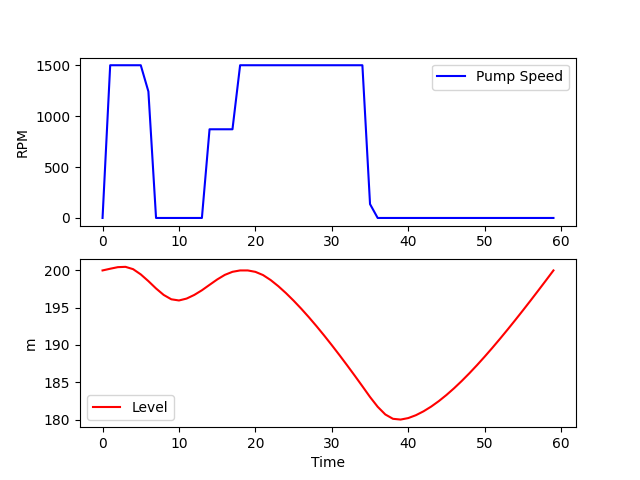

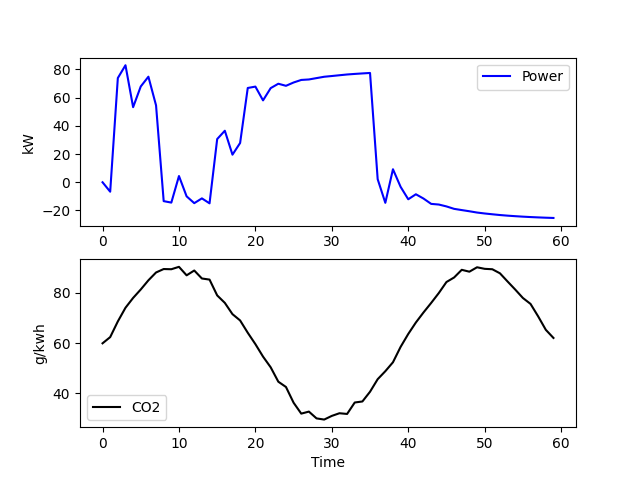

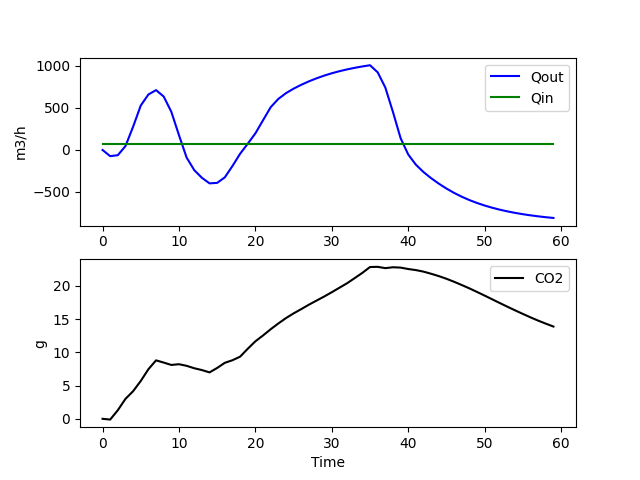

In [156]:

# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)


#Calculate the costs.
emission = 0
cost_list = []
for i in range(0,len(P)):
    emission = emission + co2[i]/3600*P[i]*Ts
    cost_list.append(emission)
print('The emitted CO2 is' ,emission, 'g') 

plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(m.time,w.value,'b-',label='Pump Speed')
plt.legend()
plt.ylabel('RPM')
plt.subplot(2,1,2, sharex=ax1)
#plt.plot(m.time,results['v3.sp'],'k-',label='Reference Trajectory')
plt.plot(m.time,h.value,'r-',label='Level')
plt.ylabel('m')
plt.xlabel('Time')
plt.legend(loc='best')

plt.figure()
plt.subplot(2,1,1, sharex=ax1)
plt.plot(m.time,P.value,'b-',label='Power')
plt.legend()
plt.ylabel('kW')
plt.subplot(2,1,2, sharex=ax1)
plt.plot(m.time,c.Value,'k-',label='CO2')
plt.ylabel('g/kwh')
plt.xlabel('Time')
plt.legend(loc='best')

plt.figure()
plt.subplot(2,1,1, sharex=ax1)
plt.plot(m.time,Qout.value,'b-',label='Qout')
plt.plot(m.time,75*np.ones(n),'g-',label='Qin')
plt.legend()
plt.ylabel('m3/h')
plt.subplot(2,1,2, sharex=ax1)
plt.plot(m.time,cost_list,'k-',label='CO2')
plt.ylabel('g')
plt.xlabel('Time')
plt.legend(loc='best')
